# MENG 37100
# Problem Set 6
# Rachel Dey

In [96]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from qutip.measurement import measure, measurement_statistics
from qutip.qip.operations import snot
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz
from scipy.optimize import curve_fit
import datetime
import qutip.control.pulseoptim as cpo
from qutip.qip.operations import cnot

## Problem 1 - Ytterbium nuclear spin qubits

### 1.a

The electronic spin states don't need to be considered in Yb and other alkaline earth-like atoms because there isn't hyperfine splitting in the J=0 ground state so the nuclear spin can be encoded in this state without consideration for the elctronic spin states. For alkali atoms like Rb and Cs, the ground state has hyperfine splitting so the electronic spin states do need to be considered.

### 1.b 

The biggest advantage of using nuclear spin states is that the absence of hyperfine coupling makes them resistant to decohering from differential light shifts or Raman scattering. This gives them a longer $T_1$ and $T_2$ time compared to alkali atoms.

The biggest challenge is that the two-qubit entangling gate only has ~83% fidelity and there has not yet been a demonstration of universal gates. The fidelity of the CZ gate that the authors implement in this paper is limited by SPAM errors and leakage to the Rydberg state.

### 1.c 

Trapping: 486.78 $\pm$ 0.1 nm $\\\\$
Initialization: uses optical pumping from |0> -> |3P1,F'=3/2,mF'=1/2>, the wavelength for this is not explicitly stated in the paper but one of the papers in the references ([47] Jenkins) that initialized with the same transition used 399 nm $\\\\$
Readout: From the |1> state, readout is performed by exciting to 3P1 as an intermediate step with 556 nm and then 308 nm to get to the 6s74s state. The states are then readout by using a 369 nm laser to get to the 6p state. $\\\\$
Single qubit manipulations: The frequency used for the RF coil is  2pi*161.7 Hz which translates to a wavelength of 2.95e5 m $\\\\$
Two qubit manipulations: The frequency for two qubit gates is 2pi*0.763 MHz which is a wavelength of 62.53 m.

### 1.d 

Text(0, 0.5, '$P_{|0>}$')

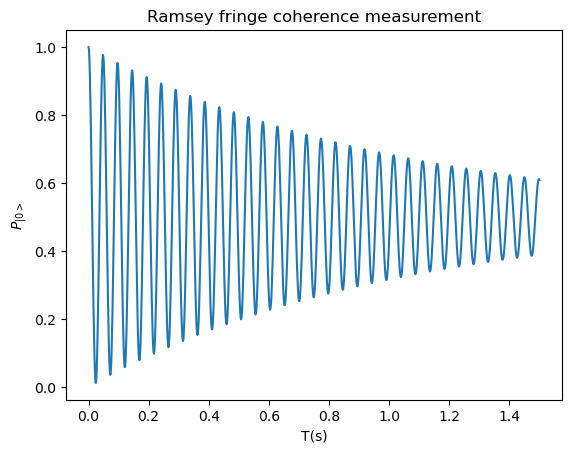

In [92]:
def gate_seq(T):
    #start in |1> state
    psi_ini = basis(2,1)
    
    #first perform X(pi/2) gate
    a = (1j+1)/2
    b = (-1j+1)/2
    xpi2 = Qobj(np.array([[a,b], [b,a]]))
    psi=xpi2*psi_ini
    
    #then let state evolve for time T
    #freq oscillations should be 2pi*161.7 Hz
    gamma = 65
    tlist = [0,T]
    H = gamma*sigmaz()
    result = sesolve(H, psi, tlist, e_ops=None)
    psi_1 = result.states
    psi_1 = psi_1[-1]
    
    #then perform R(pi/2) gate
    psi_2 = rx(np.pi/2)*psi_1
    
    #measure |0>
    c = basis(2,0).dag()*psi_2
    d = basis(2,1).dag()*psi_2
    #in 1.00s should decay to 1/e original value
    decay = np.exp(-T)
    return 0.5*(np.real(c)**2+np.imag(c)**2)[0][0]*decay+0.5*(1-(np.real(d)**2+np.imag(d)**2)[0][0]*decay)

ramsey = np.vectorize(gate_seq)
t_list = np.linspace(0,1.5,1000)
x = ramsey(t_list)
plt.plot(t_list,x)
plt.title("Ramsey fringe coherence measurement")
plt.xlabel("T(s)")
plt.ylabel(r'$P_{|0>}$')

### 1.e 

Randomized benchmarking can separate SPAM and gate errors because the probability of getting the correct output is fitted with $R_s = \frac{1}{2}+\frac{1}{2}*(1-2\epsilon_{spam})(1-2\epsilon_{gate})^d$ where d is the circuit depth. By fitting the $R_s$ vs. d graph (Figure 3d), we can obtain separate SPAM and gate errors. Since only the gate error term includes d this can be fit.

### 1.f 

The main limitations of the coherence for the single qubit manipulations is magnetic field drift during experiments arising from thermal effects. The magnetic field splits the nuclear spin hyperfine levels so it drifting will cause the states to not be separated by what they are supposed to be and driving between them will not be as coherent.

### 1.g 

In [126]:
#for |01>-|0r> basis or |10>-|r0> basis
zeta = 3.902
detuning = 0.377
rabi = 1
tau = 4.293

#first pulse
H = -detuning/2*sigmaz()+rabi/2*sigmay()
psi01 = basis(2,0)
tlist = [0,tau]
#tlist=np.linspace(0,tau,1000)
r01 = sesolve(H, psi01, tlist, e_ops=None)
r01 = r01.states[-1]
#r01 = r01.expect[0]
#plt.plot(tlist,r01)

#second pulse
H2 = -detuning/2*sigmaz()+rabi*np.exp(1j*zeta)/2*sigmay()
tlist = [0,tau]
r201 = sesolve(H2, r01, tlist, e_ops=None)
print(r201.states[-1])

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.52072337+0.30334264j]
 [0.27761286-0.74817212j]]


In [142]:
#for |11>-|W> basis
zeta = 3.902
detuning = 0.377/rabi
rabi = 2*np.pi*0.763/4.8
rabi = 1
tau = 4.293*rabi

#first pulse
H = -detuning/2*sigmaz()+rabi*np.sqrt(2)/2*sigmay()
psi01 = basis(2,0)
tlist = [0,tau]
#tlist = np.linspace(0,tau,1000)
r01 = sesolve(H, psi01, tlist, e_ops=None)
r01 = r01.states[-1]
#r=r01.expect[0]
#plt.plot(tlist,r)

#second pulse
H2 = -detuning/2*sigmaz()+rabi**np.sqrt(2)*np.exp(1j*zeta)/2*sigmay()
tlist = [0,tau]
r201 = sesolve(H2, r01, tlist, e_ops=None)
print(r201.states[-1])

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.05077614+0.6567115j ]
 [0.74960206-0.06518088j]]


## Problem 2 - High-fidelity trapped ion gates 

### 2.a

For single qubit gates the authors use F=4, mF=0 as the down state and F=3, mF=0 as the up state (both in 4s1/2). For two qubit gates the authors use F=4,mF=+4 and F=3, mF=+3.$\\\\$
They use different hyperfine states so that they can separately perform single qubit and two qubit gates with RF drives without having them interfere with one another.

### 2.b

The ions are placed 12.5 wavelengths away from each other in the trap because the half integer placement allows for control over the center of motion modes which is important in operating the two-qubit gates.

### 2.c

SPAM (state preparation and measurement) errors are errors that occur in either the preparation of the state (ie the qubit being in the up state when it was intended to be initialized in the down state) or in the measurement of the final state.$\\\\$
Figure 3a excludes SPAM errors to allow for a comparison between the error model (which only includes non-SPAM errors) and the measured error. It is justified to remove the SPAM errors to make a comparison only about the errors of the actual gate. $\\\\$
In a full quantum algorithm SPAM errors would matter because the initial state being incorrect will affect the overall fidelity as will any measurement errors at the end.

### 2.d

For the short gate time error regime (roughly from 0 to 10^1.2 $\mu$s), the gate fidelity is limited by the photon scattering error. Photon scattering error arises when the detuning of the Raman laser beam is small. However, small detuning allows for faster gates. Therefore, the shorter the gate speed the greater the photon scattering error so it makes sense that this error limits the fidelity for short gate times. The fidelity increases with the gate time in this regime. Additionally, the sinusoidal nature of the fidelity at very short gate times is caused by the off-resonant error which is also sinusoidal.$\\\\$
In the long gate time error regime (from about 10^2.1 to 10^3 $\mu$s) the gate fidelity is limited by the spin-dephasing error. Spin-dephasing error arises from magnetic field instability. The longer the gate runs the more time there is for the spin to dephase so the fidelity is lower at longer gate times.

### 2.e

As the error is limited by the photon scattering at short gate times and the spin-dephasing error at long gate times, both would be good candidates to improve to increase the overall fidelity. However, the photon scattering cannot be improved that much because it is intrinsic to the Raman beam though it could be improved somewhat (around a 4x decrease) by increasing the beam intensity. That might require acquiring a new laser which would be expensive for a limited reduction in error. The better option is therefore to reduce the spin-dephasing which can be done by increasing the magnetic field stabilization. The paper states there is around 50 Hz of magnetic field noise which could be reduced with a less noisy source.